# drosophila_simulation_experimentation

> copy of notebook `04_drosophila_simulation` for experimentation, to keep notebook 04 clean

In [ ]:
#| default_exp experimental

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso

In [ ]:
#| export
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import optimize, ndimage

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
#| export

from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
#| export

import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
#| notest

import importlib

In [ ]:
## reloading the modules in case you edit them

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

In [ ]:
## colors for cell rows

fridtjof_colors = np.array([[0.34398, 0.49112, 0.89936],
                            [0.97, 0.606, 0.081],
                            [0.91, 0.318, 0.243],
                            [0.448, 0.69232, 0.1538],
                            [0.62168, 0.2798, 0.6914],
                            [0.09096, 0.6296, 0.85532],
                            [0.46056, 0.40064, 0.81392],
                            [0.94, 0.462, 0.162],
                            [0., 0.7, 0.7],
                            [0.827051, 0.418034, 0.0243459],
                            [0.5511749434976025, 0.32014794962639853, 0.8720626412559938],
                            [0.72694101250947, 0.7196601125010522, 0.],
                            [0.8680706456216862, 0.2563858708756628, 0.30321559063052295],
                            [0.2418693812442152, 0.5065044950046278, 0.9902432574930582],
                            [0.9573908706237908, 0.5369543531189542, 0.11504464931576472]])

In [ ]:
#| export

def create_rect_initial(nx, ny, noise=0, initial_strain=0, isogonal=0, orientation='orthogonal',
                        boundaries=None, w_passive=0, w_passive_lr=0,
                        bdry_x=None, bdry_y=None,
                        random_seed=0):
    """
    Create initial condition for germ band simulations.
    
    Creates a HalfEdgeMesh from a rectangulat patch of triangular lattice, creates boundary conditions,
    selects active and passive triangles, creates a dictionary with the initial rows of active cells,
    and sets edge rest lengths and cell rest shapes.
    
    Random seed for noise can be specified for reproducible results.
    
    Parameters
    ----------
    nx, ny: int
        Width and height of rectangular patch
    noise: float
        Standard deviation of the noise added to the initial vertex positions
    initial_strain: float
        Initial y-axis strain applied to tension triangulation. Applies transform matrix
        diag(1/(1+s), 1+s)
    orientation: 'orthogonal' or 'parallel'
        Orientation of hexagonal lattice direction w.r.t. y-axis.
    boundaries: list of 'top', 'bottom', 'left', 'right'
        On which sides to add slip walls.
    w_passive: float
        Width of passive region on the top and bottom
    bdry_x, bdry_y: float
        Location of the the left/right and top/bottom slip walls. If None, set to initial mesh positions
    random_seed: int
        Numpy random number generator seed.
        
    """
    np.random.seed(random_seed)
    # create the mesh
    if orientation == 'parallel':
        nx, ny = (ny, nx)
    mesh_initial = iso.CellHalfEdgeMesh(dln.create_rect_mesh(ny, nx, noise=noise, defects=(0, 0),
                                                             straight_bdry=False))
    if orientation == 'orthogonal':
        mesh_initial.transform_vertices(dln.rot_mat(np.pi/2))
    center = np.mean([v.coords for v in mesh_initial.vertices.values()], axis=0)
    mesh_initial.transform_vertices(lambda x: x-center)
    mesh_initial.set_voronoi()
    
    mesh_initial.transform_vertices(dln.shear_mat(1+initial_strain))
    mesh_initial.set_rest_lengths()
    
    # create the boundary conditions
    boundaries = [] if boundaries is None else boundaries
    bdry_list = []
    max_x_cells = np.max([v.get_centroid()[0] for v in mesh_initial.vertices.values() if not v.is_bdry()])
    max_y_cells = np.max([v.get_centroid()[1] for v in mesh_initial.vertices.values() if not v.is_bdry()])

    bdry_x = np.ceil(max_x_cells) if bdry_x is None else bdry_x
    bdry_y = np.ceil(max_y_cells) if bdry_y is None else bdry_y
    
    w_bdry = .4
    
    if 'top' in boundaries:
        top_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[1] > (max_y_cells-w_bdry)) and (not v.is_bdry()):
                top_ids.append(v._vid)
        def top_penalty(x):
            return (x[1]-bdry_y)**2
        top_penalty = Partial(jit(top_penalty))
        bdry_list.append([top_penalty, top_ids])

    if 'bottom' in boundaries:
        bottom_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[1] < -(max_y_cells-w_bdry)) and (not v.is_bdry()):
                bottom_ids.append(v._vid)
        def bottom_penalty(x):
            return (x[1]+bdry_y)**2
        bottom_penalty = Partial(jit(bottom_penalty))
        bdry_list.append([bottom_penalty, bottom_ids])
        
    if 'left' in boundaries:
        left_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[0] < -(max_x_cells-w_bdry)) and (not v.is_bdry()):
                left_ids.append(v._vid)
        def left_penalty(x):
            return (x[0]+bdry_x)**2
        left_penalty = Partial(jit(left_penalty))
        bdry_list.append([left_penalty, left_ids])

    if 'right' in boundaries:
        right_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[0] > (max_x_cells-w_bdry)) and (not v.is_bdry()):
                right_ids.append(v._vid)
        def right_penalty(x):
            return (x[0]-bdry_x)**2
        right_penalty = Partial(jit(right_penalty))
        bdry_list.append([right_penalty, right_ids])

    # set the active and passive triangles
    passive_faces = []
    max_y_faces = np.max([val.dual_coords[1] for val in mesh_initial.faces.values()])
    max_x_faces = np.max([val.dual_coords[0] for val in mesh_initial.faces.values()])

    for fc in mesh_initial.faces.values():
        if (fc.is_bdry()
            or (np.abs(fc.dual_coords[1]) > (max_y_faces-w_passive))
            or (np.abs(fc.dual_coords[0]) > (max_x_faces-w_passive_lr))):
            passive_faces.append(fc._fid)
            
    passive_faces = sorted(passive_faces)
    passive_edges = msh.flatten([[he._heid for he in mesh_initial.faces[fc].hes] for fc in passive_faces])
    passive_cells = [v._vid for v in mesh_initial.vertices.values()
                     if not v.is_bdry() and any([fc._fid in passive_faces for fc in v.get_face_neighbors()])]

    # create dict of initial row ids
    if orientation == 'parallel':
        initial_row_dict = {key: np.round((2/np.sqrt(3))*val.get_centroid()[1]+.5, decimals=0)
                            for key, val in mesh_initial.vertices.items()
                            if (not key in passive_cells) and (not val.is_bdry())}
    elif orientation == 'orthogonal':
        initial_row_dict = {key: np.round(val.get_centroid()[1], decimals=0)
                            for key, val in mesh_initial.vertices.items()
                            if (not key in passive_cells) and (not val.is_bdry())}
    min_val = min(initial_row_dict.values())
    initial_row_dict = {key: int(val-min_val) for key, val in initial_row_dict.items()}
    
    # set isogonal mode for active cells.
    for v in mesh_initial.vertices.values():
        if v._vid in passive_cells:
            v.rest_shape = np.sqrt(3) * np.array([[1, 0],[0, 1]])
        else:
            v.rest_shape = np.sqrt(3) * np.array([[1-isogonal, 0],[0, 1+isogonal]])

    property_dict = {'initial_row_dict': initial_row_dict, 'passive_faces': passive_faces,
                     'passive_edges': passive_edges, 'passive_cells': passive_cells,
                     'bdry_x': bdry_x, 'bdry_y': bdry_y}
    
    return mesh_initial, bdry_list, property_dict

## Simulation with boundary conditions and passive & active cells

For starters, simply divide the cells into active $m=4$ and passive, $m=1$. Might be better to make this more gradual. 

### Plot initial condition

In [ ]:
#| notest
%matplotlib inline

In [ ]:
importlib.reload(msh)
importlib.reload(tns)
importlib.reload(dln)
importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

In [ ]:
## create and plot the initial condition

mesh_initial, bdry_list, property_dict = create_rect_initial(16, 20, noise=0.15, initial_strain=0.1,
                                                             orientation='orthogonal', isogonal=0,
                                                             boundaries=['top', 'bottom', 'left', 'right'],
                                                             w_passive=4, w_passive_lr=1.5, random_seed=0)

In [ ]:
# set colors for edges and cells
edge_colors = {key: "tab:grey" for key in property_dict['passive_edges']}
cell_alpha = .5
cell_colors = {key: np.hstack([fridtjof_colors[val % fridtjof_colors.shape[0]], [cell_alpha]])
               for key, val in property_dict['initial_row_dict'].items()}

(-9.5, 9.5)

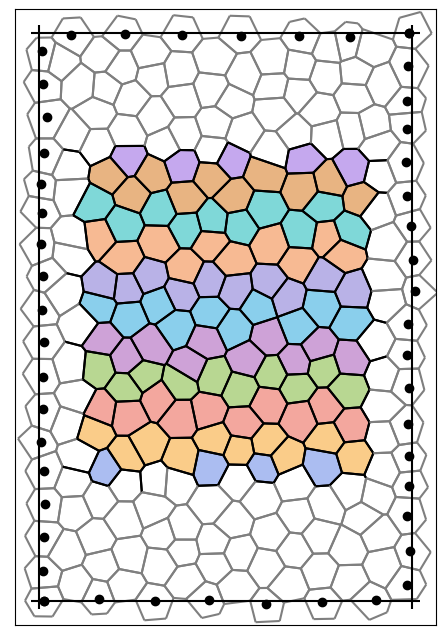

In [ ]:
fig = plt.figure(figsize=(8,8))

mesh_initial.cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
#mesh_initial.triplot()
#mesh_initial.labelplot()

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict['bdry_x'], property_dict['bdry_y'])
plt.hlines((bdry_y-.25, -bdry_y+.25), (-bdry_x, -bdry_x), (bdry_x, bdry_x), color="k")
plt.vlines((bdry_x-.25, -bdry_x+.25), (-bdry_y, -bdry_y), (bdry_y, bdry_y), color="k")


for key in msh.flatten([x[1] for x in bdry_list]):
    plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="k")

plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-bdry_x-.5, bdry_x+.5])
plt.ylim([-bdry_y-.5, bdry_y+.5])

#plt.savefig("plots/for_figure_v2/initial_cond_cauterized.pdf")

## set simulation parameters

In [ ]:
# might need much larger k for passive

In [ ]:
## feedback parameters

m = 4
k = 4  # . 5
k_cutoff = .25 # regularization term
 
passive_ids = property_dict['passive_faces']
def params_pattern(fid):
    if fid in passive_ids:
        return {"k": .5, "m": 1} # lower k here makes the passive region less lattice-like
    # might add an extra case for the edges in slip-wall boundary cells
    return {"k": k, "m": m, "k_cutoff": k_cutoff}

params_no_pattern = {"k": k, "m": m, "k_cutoff": k_cutoff}
    
dt = .001 # time step
n_steps = 200
forbid_reflip = 20
minimal_l = .05 # .075 inimal edge length, lower edge lengths trigger T1

tri_mod_area = .02 # .01 triangle area regularization

In [ ]:
## cell shape parameters

tol, maxiter = (1e-5, 100000)  #1e-4
mod_bulk = 1
mod_shear = .5
angle_penalty = 1000
bdry_penalty = 5000

epsilon_l = .5*1e-4  # interesting. going below 1e-3 leads the optimizer to fail, typically.

A0 = jnp.sqrt(3)/2
mod_area = 0.2

bdr_weight = 4 # 2

passive_cells = property_dict['passive_cells']
rel_elastic_modulus = .8 # reduction in elastic modulus in passive cells
cell_id_to_modulus = np.vectorize(lambda x: 1-rel_elastic_modulus*(x in passive_cells))

use_voronoi = False # don't do shape optimization, run voronoi instead

In [ ]:
# package all into a single dict to pass to the optimizer method

energy_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear,
               "angle_penalty": angle_penalty, "bdry_penalty": bdry_penalty, "epsilon_l": epsilon_l,
               "A0": A0, "mod_area": mod_area}
optimizer_args = {'bdry_list': bdry_list, 'energy_args': energy_args, 'cell_id_to_modulus': cell_id_to_modulus,
                  'tol': tol, 'maxiter': maxiter, 'verbose': True, 'bdr_weight': bdr_weight}

In [ ]:
## rest length relaxation

k_rest = 2

def rhs_rest_shape(v):
    """Rest shape relaxation but do not relax area, i.e. trace. Also, only relax passive cells"""
    #if v._vid in property_dict['passive_cells']:
    #    delta = v.rest_shape-v.get_vrtx_shape_tensor()
    #    return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))
    #else:
    #    return 0
    #delta = v.rest_shape-v.get_vrtx_shape_tensor()
    #return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))
    return -k_rest * (v.rest_shape - np.sqrt(3)*np.eye(2))

## Simulation loop

Note: when saving, we need to save some additional data (the passive tensions and the cell rest shapes) which are not by default saved by the `HalfEdgeMesh` save routine. They are saved as dicts, so that after loading the properties can be set again, for example to continue simulating.

Few if any recompilations during simulation run according to `get_E._cache_size(), get_E_jac._cache_size()`

In [ ]:
meshes = [deepcopy(mesh_initial)]
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

In [ ]:
save = True
save_dir = "runs/cauterized_low_l_min/"
try:
    os.mkdir(save_dir)
except FileExistsError:
    print('Warning: directory exists')

In [ ]:
## simulation loop

mesh = deepcopy(meshes[-1])
for i in tqdm(range(0, n_steps)):
    # euler step
    mesh.euler_step(dt=dt, rhs_tension=tns.excitable_dt_act_pass, params=params_pattern,
                    rhs_rest_shape=rhs_rest_shape)
    # flatten triangulation
    mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4)
    # primal optimization
    if use_voronoi:
        mesh.set_voronoi()
    else:
        mesh.optimize_cell_shape(**optimizer_args)
    # check for intercalation
    flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                            minimal_l=minimal_l, reoptimize=False, optimizer_args=optimizer_args)
    if failed_flip:
        print(f"tpt {i}: flip {flipped}, failed {failed_flip}")
    else:
        print(f"tpt {i}: flip {flipped}")
    # rescale & reorient triangulation
    mesh.transform_vertices(dln.get_conformal_transform(meshes[-1], mesh))
    # log & save
    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)
    if save:
        mesh.save_mesh(f"{save_dir}/{str(i).zfill(4)}_mesh", save_attribs=True)
last_flipped_edges.append([])

  0%|          | 0/200 [00:00<?, ?it/s]

Cell shape optimization failed Maximum number of iterations has been exceeded.
tpt 0: flip [567, 813, 465, 762, 1065, 417, 1423, 522, 991, 571, 810, 721, 1497, 532]
Cell shape optimization failed Maximum number of iterations has been exceeded.
tpt 1: flip [649, 816, 24, 469, 165, 61, 484, 1384, 817, 7]


KeyboardInterrupt: 

In [ ]:
meshes[-1].is_consistent()

# inconsistent mesh created!
# I flipped two edges of the same triangle in succession

True

### Loading a saved simulation

### Analyze a simulation

Shows several types of plots

#### Slider plots

Most importantly, visualize the mesh

In [ ]:
def plot_mesh(i, xlim, ylim, mesh_series, flipped_series=None,
              edge_colors=None, cell_colors=None, slipwall_y=None, plot_cell=True, plot_tri=False):
    """
    Plot time series of meshes (simulation results).
    
    This function is used primarily for interactive slider plots, and to create movies.
    Usage example, using widget.fixed to set the args you do not want to tune interactively:
    
    fig = plt.figure(figsize=(6, 6))
    widgets.interact(plot_mesh, i=(0, len(meshes)-1, 1), xlim=(bdry_x, 2*bdry_x),
                 ylim=widgets.fixed(bdry_y+.5), edge_colors=None, cell_colors=None,
                 mesh_series=widgets.fixed(meshes), flipped_series=widgets.fixed(last_flipped_edges));
    
    Parameters
    ----------
    i: int
        Time point to plot
    xlim, ylim: float
        x- and y- limits of the axes, symmetric about 0.
    mesh_series, flipped_series: list
        Time series of meshes and T1 events, as given by simulation loop
    edge_colors, cell_colors: dict
        color dict, see mesh.cell_plot
    slipwall_y: float or None
        If float, plot slip walls at top/bottom at this position. If None, don't plot anything. 
    plot_cell, plot_tri: bool
        plot cells and/or triangulation
    """
    
    plt.cla()
    if slipwall_y is not None:
        plt.hlines((bdry_y, -bdry_y), (-xlim, -xlim), (xlim, xlim), color="k")
    plt.xlim([-xlim, xlim])
    plt.ylim([-ylim, ylim])
    plt.gca().set_aspect("equal", adjustable="box")
    if plot_cell:
        mesh_series[i].cellplot(edge_colors=edge_colors,
                                cell_colors=cell_colors)
    #meshes[i].labelplot(halfedge_labels=True, vertex_labels=True, face_labels=False)
    if plot_tri:
        mesh_series[i].triplot()
    plt.title(i)
    if flipped_series is not None:
        for x in flipped_series[i+1]:
            he = meshes[i].hes[x]
            if plot_cell:
                line = np.stack([he.face.dual_coords, he.twin.face.dual_coords])
                plt.plot(*line.T, c="r", lw=4)
            if plot_tri:
                line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
                plt.plot(*line.T, c="tab:purple", lw=5)

In [ ]:
# in this example, we get basically _no_ elongation of new junctions!

# test: area modulus. also no
# heterogeneity in elastic moduli!

<IPython.core.display.Javascript object>


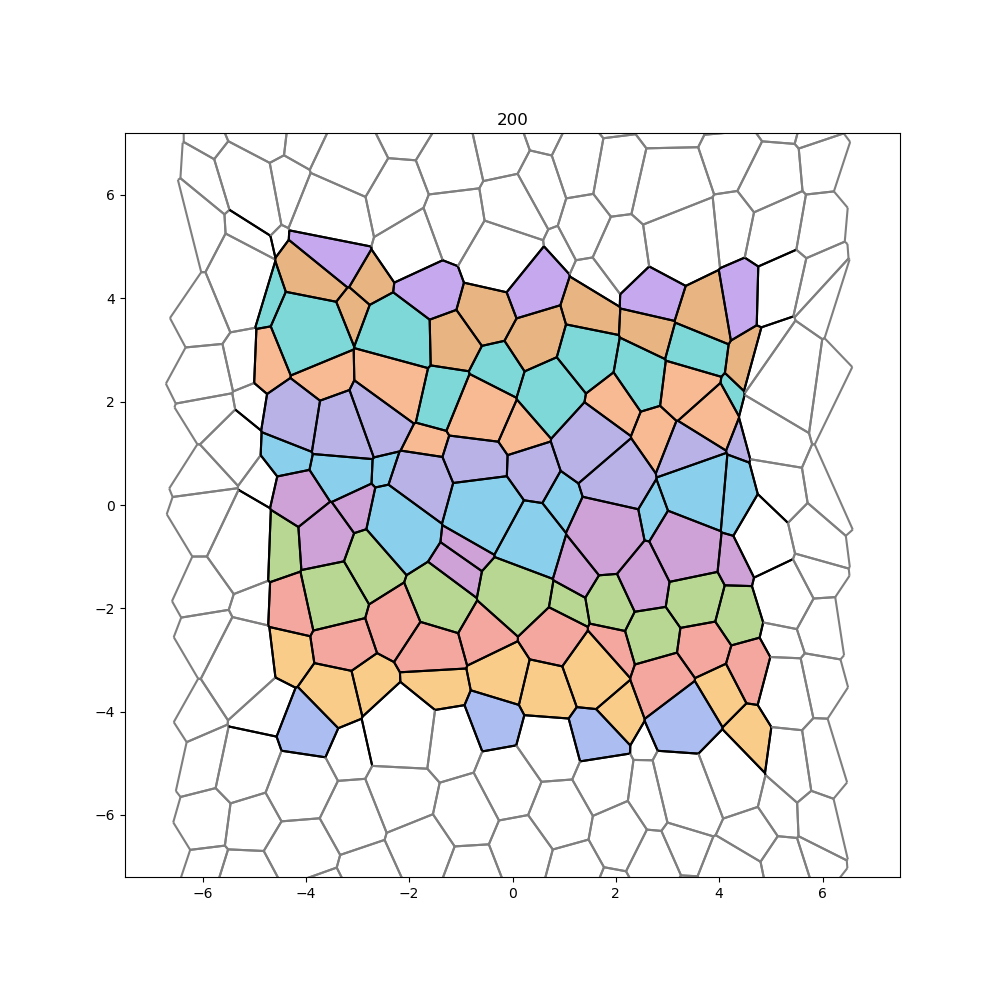

interactive(children=(IntSlider(value=100, description='i', max=200), FloatSlider(value=7.5, description='xlim…

In [ ]:
#| notest

%matplotlib notebook

fig = plt.figure(figsize=(10, 10))
    
# fix the arguments which you do not need to tune with widgets.fixed

widgets.interact(plot_mesh, i=(0, len(meshes)-1, 1),
                 xlim=(1/2*bdry_x, 2*bdry_x),
                 ylim=(bdry_y/2, 1.1*bdry_y),
                 #ylim=widgets.fixed(bdry_y+.5),
                 slipwall_y=widgets.fixed(bdry_y),
                 edge_colors=widgets.fixed(edge_colors), cell_colors=widgets.fixed(cell_colors),
                 mesh_series=widgets.fixed(meshes),
                 #flipped_series=widgets.fixed(None),
                 flipped_series=widgets.fixed(last_flipped_edges)
                );

In [ ]:
#| notest
%matplotlib inline

#### Energies & areas

In [ ]:
# calculate the shape tensor energies

energies = [{key: val for key, val in msh.get_shape_energies(mod_bulk=mod_bulk, mod_shear=mod_shear).items()
             if val is not None} for msh in meshes]
angle_penalties = [msh.get_angle_deviation() for msh in meshes]

(0.0, 0.005)

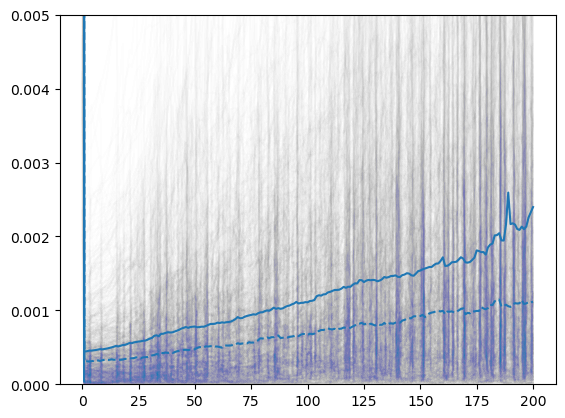

In [ ]:
## time series plot of angle penalties - sin(deviation from triangulation angle)

a_time = np.array([[e[key] for e in angle_penalties] for key in angle_penalties[0].keys()])
plt.plot(a_time.T, color="tab:blue", alpha=.005);
plt.plot(np.mean(a_time, axis=0), color="tab:blue", alpha=1);
plt.plot(np.median(a_time, axis=0), color="tab:blue", alpha=1, ls="--");

plt.ylim([0, 5*1e-3])

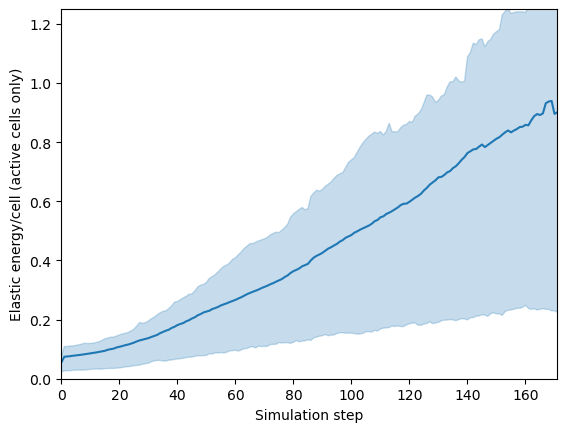

In [ ]:
## time series plot of energies

e_time = np.array([[e[key] for e in energies] for key in energies[0].keys()
                   if not key in property_dict['passive_cells']])
#plt.plot(e_time.T, color="tab:blue", alpha=.1);
mean = e_time.mean(axis=0)
err_down, err_up = (np.quantile(e_time, .25, axis=0,), np.quantile(e_time, .75, axis=0,))

plt.plot(mean, color="tab:blue", alpha=1);
plt.fill_between(np.arange(e_time.shape[1]), err_down, err_up,
         color="tab:blue", alpha=.25);

plt.xlabel('Simulation step')
plt.ylabel('Elastic energy/cell (active cells only)')

plt.xlim([0, 171])
plt.ylim([0, 1.25*1e0])


plt.savefig('plots/for_figure_v2/energy_vs_time_quartile_error.pdf', bbox_inches='tight')

<matplotlib.collections.PathCollection>

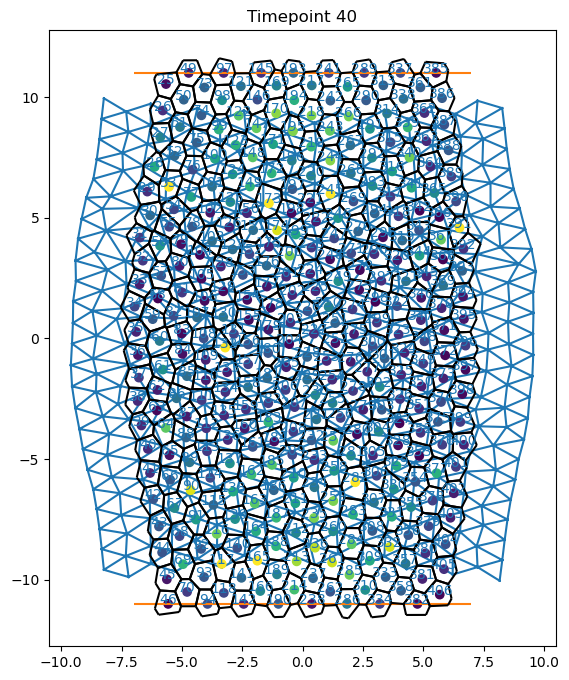

In [ ]:
## spatial plot of shape energies

i = 40

fig = plt.figure(figsize=(8,8))

plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")
plt.xlim([-1.5*bdry_x, 1.5*bdry_x])

plt.gca().set_aspect("equal", adjustable="box")
meshes[i].cellplot()
meshes[i].triplot()
meshes[i].labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

plt.title(f'Timepoint {i}');

# now calculate the energies and centroids
for_scttr = np.stack([np.hstack([meshes[i].vertices[key].get_centroid(), [val]])
                      for key, val in energies[i].items()], axis=1)
plt.scatter(*for_scttr[:2], c=for_scttr[2], vmin=0, vmax=.5)

(0.0, 1.7320508075688772)

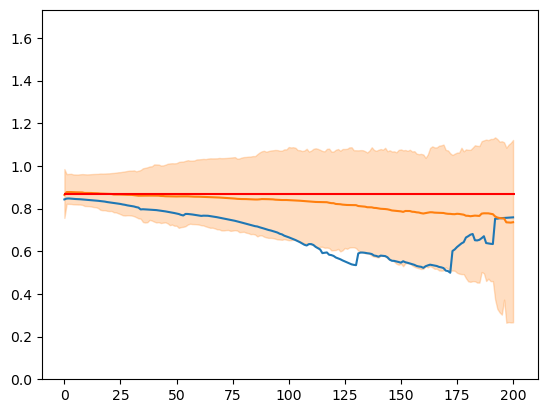

In [ ]:
# create a time-series of areas

areas = np.stack([[x for x in mesh.get_areas().values() if x is not None] for mesh in meshes])

plt.plot(areas[:, 3]) # an example trajectory
mean = areas.mean(axis=1)
plt.plot(mean)
plt.fill_between(np.arange(areas.shape[0]), np.quantile(areas, .05, axis=1),
                 np.quantile(areas, .95, axis=1), color="tab:orange", alpha=.25)

plt.hlines(np.sqrt(3)/2, 0, len(meshes), color="r")
plt.ylim([0, np.sqrt(3)])

#### Measure the amount of extension

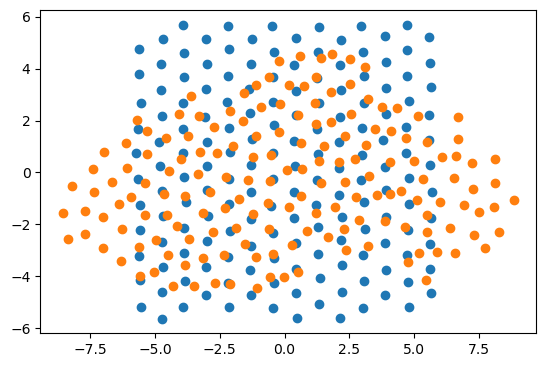

In [ ]:
# overlay initial and final positions of active cell vertices

centroids = np.stack([[v.get_centroid() for key, v in mesh.vertices.items()
                       if key not in passive_cells and not v.is_bdry()] for mesh in meshes[1:]])

plt.scatter(*centroids[0].T)
plt.scatter(*centroids[-1].T)

plt.gca().set_aspect("equal", adjustable="box")

[<matplotlib.lines.Line2D>]

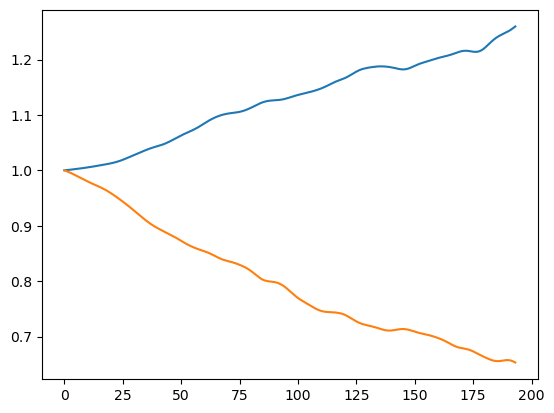

In [ ]:
# plot width and height
delta = np.quantile(centroids, axis=1, q=.9)-np.quantile(centroids, axis=1, q=.1,)
delta_smooth = ndimage.gaussian_filter1d(delta, axis=0, sigma=sigma)[sigma:-sigma]
delta_smooth /= delta_smooth[0]

sigma = 3 # smooth

plt.plot(delta_smooth[:,0])
plt.plot(delta_smooth[:,1])

#### Plot cell trajectories, color-coded by time

In [ ]:
trajectories = [[val.get_centroid() for key, val in mesh.vertices.items()
                if (not mesh_initial.vertices[key].is_bdry())] for mesh in meshes[1:]]

trajectories = np.stack(trajectories).transpose((1,0,2))

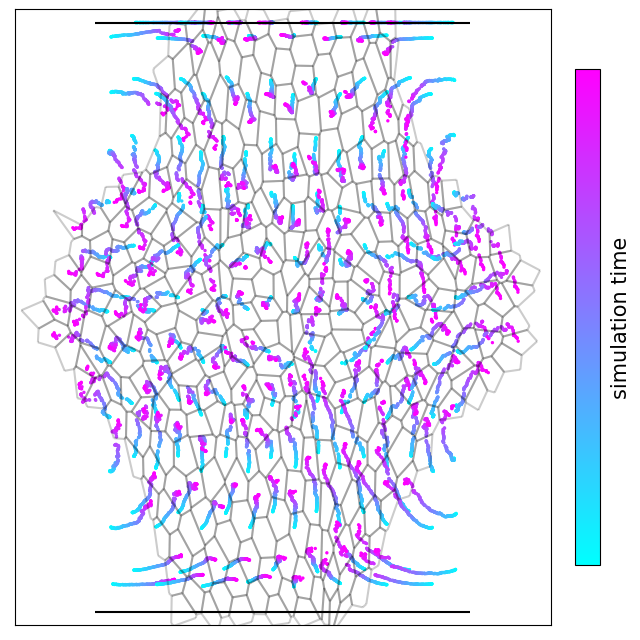

In [ ]:
fig = plt.figure(figsize=(8,8))

t = np.arange(trajectories.shape[1])

stop = 170

for traj in trajectories[::2]:
    plt.scatter(*traj[:stop].T, s=2, c=t[:stop], cmap="cool")

cb = plt.colorbar(fraction=0.04, pad=0.04)
cb.set_ticks([])
cb.set_label(label='simulation time', fontsize=15)

meshes[stop].cellplot(alpha=.2)

plt.xticks([],[])
plt.yticks([],[])

plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="black", label="slip wall")
plt.xlim([-10, 10])
plt.ylim([-bdry_y-.5, bdry_y+.5])
plt.gca().set_aspect("equal", adjustable="box")

plt.savefig("plots/for_figure_v2/trajectories.pdf")

#### Plot small snapshots

In [ ]:
#| notest
def plot_snapshot(i, xlim, ylim):
    plt.cla()
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xticks([],[])
    plt.yticks([],[])

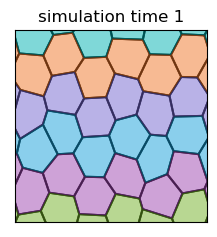

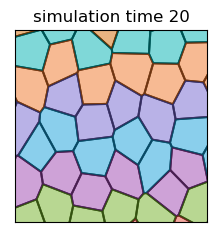

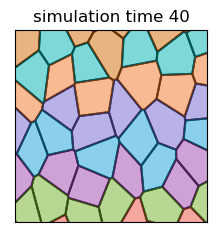

In [ ]:
for i in [1, 20, 40]:
    fig = plt.figure(figsize=(2.5, 2.5))
    plot_snapshot(i, xlim=[-2.5, 2.5], ylim=[-2, 3])
    plt.title(f'simulation time {i}')
    plt.show()


#### Vertex-model order parameter

Measure the ratio of perimeter and area: $P/\sqrt{A}$. A measure of tissue disorder.


In [ ]:
#| export

def get_p_over_sqrt_A(v: msh.Vertex) -> float:
    """Compute perimeter/sqrt(area) of cell. Returns None for boundary cells."""
    if v.is_bdry():
        return None
    cell = np.stack([fc.dual_coords for fc in v.get_face_neighbors()])
    return tns.polygon_perimeter(cell) / np.sqrt(tns.polygon_area(cell))

In [ ]:
get_p_over_sqrt_A(meshes[10].vertices[70])

DeviceArray(3.77045812, dtype=float64)

In [ ]:
P_over_A = np.stack([[get_p_over_sqrt_A(v) for key, v in mesh.vertices.items()
                      if key not in passive_cells and not v.is_bdry()] for mesh in meshes[1:]])

<matplotlib.legend.Legend>

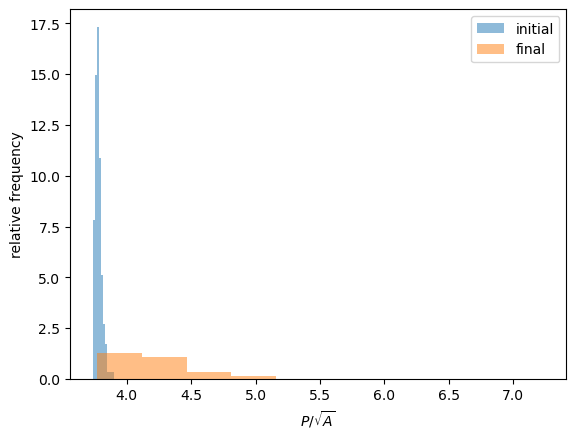

In [ ]:
plt.hist(P_over_A[0], alpha=.5, label='initial', density=True, bins=10);
plt.hist(P_over_A[-1], alpha=.5, label='final', density=True, bins=10);

plt.xlabel(r'$P / \sqrt{A}$')
plt.ylabel('relative frequency')
plt.legend()

#### Dual shape factor distribution

Fairly "grainy" due to the small mesh size.

In [ ]:
angle_series = [mesh.get_vertex_angles(exclude=passive_ids, method="dual") for mesh in meshes[1:]]

dsf_series = np.stack([tns.angles_shape(np.array(list(x.values())).T) for x in angle_series])

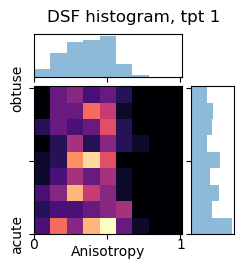

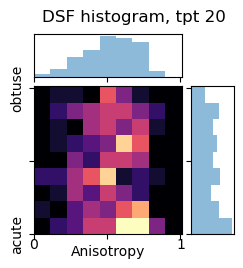

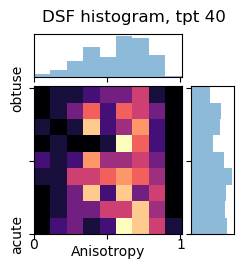

In [ ]:
for i in [1, 20, 40]:

    fig = plt.figure(figsize=(2.5, 2.5))
    fig.suptitle(f'DSF histogram, tpt {i}', y=1.)

    bins = [dln.eqspace(0, 1+.01, .1), dln.eqspace(0, 1+.01, .1)]
    ax = dln.scatter_hist(dsf_series[i,1], dsf_series[i,0]/np.pi, bins, fig=fig)

    ax.set_ylabel("", labelpad=-5)
    ax.set_xlabel("Anisotropy", labelpad=-5)
    ax.set_xticks([0, 1/2, 1], [0, "", 1], rotation=0, va='center') 
    ax.set_yticks([0, 1/2, 1], ["acute", "", r"obtuse"], rotation=90, va='center')
    #ax.set_aspect('equal', adjustable='box')
    plt.show()

[<matplotlib.axis.XTick>,
 <matplotlib.axis.XTick>,
 <matplotlib.axis.XTick>]

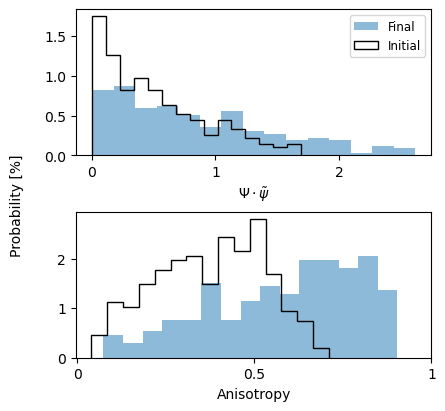

In [ ]:
## plot the "bridge" order parameter and anisotropy

fig, (ax1, ax2) = plt.subplots(figsize=(4,4), ncols=1, nrows=2, constrained_layout = True)

t_sim = -1
n_bins = 15

ax1.hist(np.prod(dsf_series[t_sim], axis=0), alpha=.5, bins=n_bins, density=True, label='Final');
ax1.hist(np.prod(dsf_series[1], axis=0), bins=n_bins, density=True, label='Initial',
         histtype='step', color='k', );

ax1.set_xlabel(r"$\Psi\cdot\tilde{\psi}$",)
ax1.legend(fontsize=8.5)

ax2.hist(dsf_series[t_sim][1], alpha=.5, bins=n_bins, density=True, label='Final');
ax2.hist(dsf_series[2][1], bins=n_bins, density=True, label='Initial',
         histtype='step', color='k', );

ax2.set_xlabel(r"Anisotropy")
fig.text(-0.075, 0.5, 'Probability [%]', va='center', rotation='vertical')

ax1.set_xticks([0, 1, 2], [0, 1, 2])
ax2.set_xticks([0, 0.5, 1,], [0, 0.5, 1,])